In [1]:
# python
import os
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, llpnanoaodschema
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from hist import intervals
import coffea.util
# import numpy as np
import mplhep as hep

In [2]:
import yaml
yaml_file_path = '../../configs/ntuples/signal_2mu2e_v10.yaml'
# Open and read the YAML file
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)
signals_all = list(data["llpNanoAOD_v2"]["samples"].keys())
for x in range(len(signals_all)):
    print("'" + signals_all[x] + "',")

'2Mu2E_100GeV_0p25GeV_0p02mm',
'2Mu2E_100GeV_0p25GeV_0p2mm',
'2Mu2E_100GeV_0p25GeV_2p0mm',
'2Mu2E_100GeV_0p25GeV_10p0mm',
'2Mu2E_100GeV_0p25GeV_20p0mm',
'2Mu2E_100GeV_1p2GeV_0p096mm',
'2Mu2E_100GeV_1p2GeV_0p96mm',
'2Mu2E_100GeV_1p2GeV_9p6mm',
'2Mu2E_100GeV_1p2GeV_48p0mm',
'2Mu2E_100GeV_1p2GeV_96p0mm',
'2Mu2E_100GeV_5p0GeV_0p4mm',
'2Mu2E_100GeV_5p0GeV_4p0mm',
'2Mu2E_100GeV_5p0GeV_40p0mm',
'2Mu2E_100GeV_5p0GeV_200mm',
'2Mu2E_100GeV_5p0GeV_400mm',
'2Mu2E_150GeV_0p25GeV_0p013mm',
'2Mu2E_150GeV_0p25GeV_0p13mm',
'2Mu2E_150GeV_0p25GeV_1p3mm',
'2Mu2E_150GeV_0p25GeV_6p7mm',
'2Mu2E_150GeV_0p25GeV_13p0mm',
'2Mu2E_150GeV_1p2GeV_0p064mm',
'2Mu2E_150GeV_1p2GeV_0p64mm',
'2Mu2E_150GeV_1p2GeV_6p4mm',
'2Mu2E_150GeV_1p2GeV_32p0mm',
'2Mu2E_150GeV_1p2GeV_64p0mm',
'2Mu2E_150GeV_5p0GeV_0p27mm',
'2Mu2E_150GeV_5p0GeV_2p7mm',
'2Mu2E_150GeV_5p0GeV_27p0mm',
'2Mu2E_150GeV_5p0GeV_130p0mm',
'2Mu2E_150GeV_5p0GeV_270p0mm',
'2Mu2E_200GeV_0p25GeV_0p01mm',
'2Mu2E_200GeV_0p25GeV_0p1mm',
'2Mu2E_200GeV_0p25GeV_1p0mm',
'2Mu2

In [3]:
S  = [
'2Mu2E_500GeV_5p0GeV_0p8mm', 
'2Mu2E_500GeV_5p0GeV_80p0mm',
'2Mu2E_500GeV_0p25GeV_0p004mm',
'2Mu2E_500GeV_0p25GeV_4p0mm',
]
output_signal = coffea.util.load( "output_signal_base_ljObjCut_ljIso_2lj.coffea" )
output_signal["out"]["2Mu2E_500GeV_5p0GeV_0p8mm"]

{'cutflow': {'base_ljObjCut_ljIso_2lj': <sidm.tools.cutflow.Cutflow at 0x7fafbed48b90>},
 'hists': {'mulj_egmlj_invmass': Hist(
    StrCategory(['base_ljObjCut_ljIso_2lj'], name='channel'),
    Regular(100, 0, 1200, name='ljlj_mass', label='Invariant Mass ($LJ_{0}$, $LJ_{1}$)'),
    storage=Weight()) # Sum: WeightedSum(value=16.9074, variance=0.00531014),
  'mulj_egmlj_invmass_pixelHits_lostHits': Hist(
    StrCategory(['base_ljObjCut_ljIso_2lj'], name='channel'),
    Regular(100, 0, 1200, name='ljlj_mass', label='Invariant Mass ($LJ_{0}$, $LJ_{1}$)'),
    storage=Weight()) # Sum: WeightedSum(value=1.02262, variance=0.000321175),
  'mulj_egmlj_invmass_trkLayers_lostHits': Hist(
    StrCategory(['base_ljObjCut_ljIso_2lj'], name='channel'),
    Regular(100, 0, 1200, name='ljlj_mass', label='Invariant Mass ($LJ_{0}$, $LJ_{1}$)'),
    storage=Weight()) # Sum: WeightedSum(value=0.427765, variance=0.000134349),
  '1pf_mulj_egmlj_invmass': Hist(
    StrCategory(['base_ljObjCut_ljIso_2lj'], na

In [4]:
QCD=[ 
     "QCD_Pt15To20", 
     "QCD_Pt20To30",
     "QCD_Pt30To50",
     "QCD_Pt50To80",
     "QCD_Pt80To120",
     "QCD_Pt120To170",
    "QCD_Pt170To300",
    "QCD_Pt300To470",
     "QCD_Pt470To600",
     "QCD_Pt600To800",
    "QCD_Pt800To1000",
     "QCD_Pt1000",
    ]
DY = [ 
    "DYJetsToMuMu_M10to50",
     # "DYJetsToMuMu_M50",
     ]
TT = [ 
     "TTJets",
     ]

bgs= QCD + DY + TT


In [10]:
def sum_bgs_hist(bgs_list, histogram_name, channel_name):
    """
    Sum histograms for a list of backgrounds.
    """
    summed_hist = None
    
    for x in bgs_list:
        print(x)
        output_bg = coffea.util.load(f"output_{x}{channel_name}.coffea")
        hist = output_bg["out"][x]["hists"][histogram_name][channel_name, ::4j]
        
        if summed_hist is None:
            summed_hist = hist.copy()
        else:
            summed_hist += hist
    
    return summed_hist


QCD_Pt15To20
QCD_Pt20To30
QCD_Pt30To50
QCD_Pt50To80
QCD_Pt80To120
QCD_Pt120To170
QCD_Pt170To300
QCD_Pt300To470
QCD_Pt470To600
QCD_Pt600To800
QCD_Pt800To1000
QCD_Pt1000
DYJetsToMuMu_M10to50
TTJets


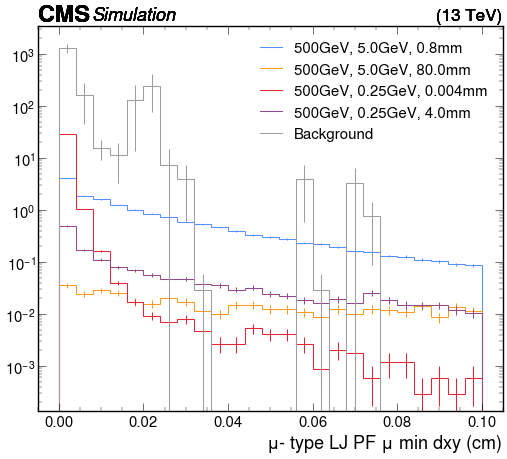

In [11]:
label_list =[]
histogram_name = "mu_lj_pfMuon_min_dxy_XLowRange"
channel_name = "base_ljObjCut_ljIso_2lj"
sum_bg = sum_bgs_hist(bgs, histogram_name,channel_name )
plt.figure(figsize=(12, 10))
for s in S:
    histogram = output_signal["out"][s]["hists"][histogram_name][channel_name, ::4j]
    parts = s.split("_")
    mass = parts[1]
    zd_mass = parts[2].replace("p", ".")
    ctau = parts[3].replace("p", ".").replace("mm", "")
    label = mass + ", "  + zd_mass + ", " + ctau + "mm"
    label_list.append(label)
    utilities.plot(histogram, flow ="none", yerr=True)
utilities.plot(sum_bg, yerr=True, flow=None)
plt.yscale("log")

plt.legend(label_list + ["Background"])
    

QCD_Pt15To20
QCD_Pt20To30
QCD_Pt30To50
QCD_Pt50To80
QCD_Pt80To120
QCD_Pt120To170
QCD_Pt170To300
QCD_Pt300To470
QCD_Pt470To600
QCD_Pt600To800
QCD_Pt800To1000
QCD_Pt1000
DYJetsToMuMu_M10to50
TTJets


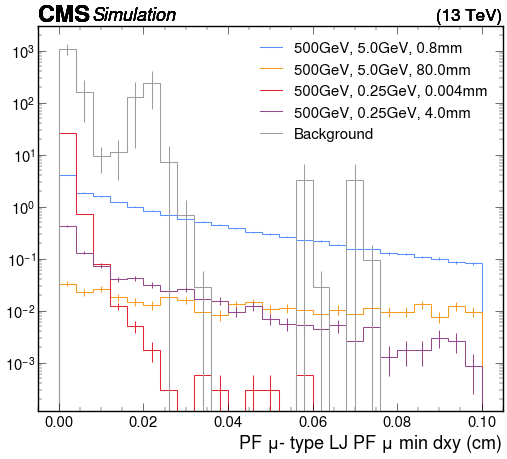

In [13]:
label_list =[]
histogram_name = "pf_mu_lj_pfMuon_min_dxy_XLowRange"
channel_name = "base_ljObjCut_ljIso_2lj"
sum_bg = sum_bgs_hist(bgs, histogram_name,channel_name )
plt.figure(figsize=(12, 10))
for s in S:
    histogram = output_signal["out"][s]["hists"][histogram_name][channel_name, ::4j]
    parts = s.split("_")
    mass = parts[1]
    zd_mass = parts[2].replace("p", ".")
    ctau = parts[3].replace("p", ".").replace("mm", "")
    label = mass + ", "  + zd_mass + ", " + ctau + "mm"
    label_list.append(label)
    utilities.plot(histogram, flow ="none", yerr=True)
utilities.plot(sum_bg, yerr=True, flow=None)
plt.yscale("log")

plt.legend(label_list + ["Background"])
    

QCD_Pt15To20
QCD_Pt20To30
QCD_Pt30To50
QCD_Pt50To80
QCD_Pt80To120
QCD_Pt120To170
QCD_Pt170To300
QCD_Pt300To470
QCD_Pt470To600
QCD_Pt600To800
QCD_Pt800To1000
QCD_Pt1000
DYJetsToMuMu_M10to50
TTJets


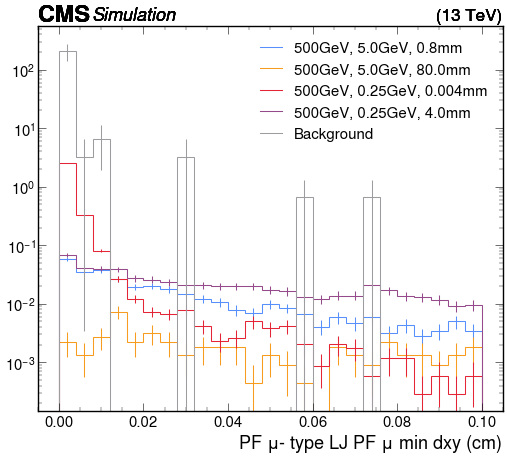

In [15]:
label_list =[]
histogram_name = "pf_dsa_mu_lj_pfMuon_min_dxy_XLowRange"
channel_name = "base_ljObjCut_ljIso_2lj"
sum_bg = sum_bgs_hist(bgs, histogram_name,channel_name )
plt.figure(figsize=(12, 10))
for s in S:
    histogram = output_signal["out"][s]["hists"][histogram_name][channel_name, ::4j]
    parts = s.split("_")
    mass = parts[1]
    zd_mass = parts[2].replace("p", ".")
    ctau = parts[3].replace("p", ".").replace("mm", "")
    label = mass + ", "  + zd_mass + ", " + ctau + "mm"
    label_list.append(label)
    utilities.plot(histogram, flow ="none", yerr=True)
utilities.plot(sum_bg, yerr=True, flow=None)
plt.yscale("log")

plt.legend(label_list + ["Background"])
    